In [1]:
import os
import sys
import re
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.io import cellranger_umi

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2018-11-01 
Git hash:


In [3]:
cluster_annot = {
    0: 'LS',
    1: 'MC',
    2: 'MS',
    3: 'ES',
    4: 'LC',
    5: 'EC',
    6: 'SP',
    7: 'TE',
    8: 'PC',
    9: 'U9',
    10: 'U10',
    11: 'U11'
}

cluster_order = [
    'SP',
    'ES',
    'MS',
    'LS',
    'EC',
    'MC',
    'LC',
    'TE',
    'PC',
    'U9',
    'U10',
    'U11'
]

In [4]:
clusters = nbconfig.seurat.get_clusters('res.0.6')
clusters = clusters.map(cluster_annot)
clusters = pd.Series(pd.Categorical(clusters, categories=cluster_order, ordered=True), index=clusters.index)
clusters.name = 'cluster'

In [5]:
def munge(fname, rep):
    dat = cellranger_umi(fname).groupby('cell_id').size()
    dat.name = 'umi_count'
    dat.index = f'{rep}_' + dat.index.values
    dat = pd.concat([dat, clusters], axis=1, sort=True)
    dat.sort_values('umi_count', ascending=False, inplace=True)
    dat['cell_rank'] = range(1, dat.shape[0] + 1)
    dat['dups'] = False
    dat['dupFinder'] = False
    
    with open(f'../output/notebook/2018-10-29_testing_doubletdetection_{rep}.txt') as fh:
        dups = fh.read().strip().split('\n')
        dat.loc[dups, 'dups'] = True
        
    with open(f'../output/notebook/2018-10-30_testing_doubletFinder_{rep}.txt') as fh:
        dups = fh.read().strip().split('\n')
        dat.loc[dups, 'dupFinder'] = True
    
    return dat

In [20]:
def plot_knee(dat, ax, title='All Cells', **kwargs):
    args = dict(x='cell_rank', y='umi_count', s=10, alpha=.8, color='grey', ax=ax)
    args.update(kwargs)
    dat.plot.scatter(**args)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.axhline(10**5, ls='--', color='red', lw=.8)
    ax.set_title(title, fontsize=8)
    
def plotall(dat, title):
    # figure layout
    fig = plt.figure(figsize=plt.figaspect(1/2))
    fig.suptitle(title, fontsize=12)
    
    gs = GridSpec(4, 4, height_ratios=[3, 1, 1, 1], wspace=.1)

    ax0 = fig.add_subplot(gs[0, :])

    ax1 = fig.add_subplot(gs[1, 0], sharex=ax0, sharey=ax0)
    ax2 = fig.add_subplot(gs[1, 1], sharex=ax0, sharey=ax0)
    ax3 = fig.add_subplot(gs[1, 2], sharex=ax0, sharey=ax0)
    ax4 = fig.add_subplot(gs[1, 3], sharex=ax0, sharey=ax0)

    ax5 = fig.add_subplot(gs[2, 0], sharex=ax0, sharey=ax0)
    ax6 = fig.add_subplot(gs[2, 1], sharex=ax0, sharey=ax0)
    ax7 = fig.add_subplot(gs[2, 2], sharex=ax0, sharey=ax0)
    ax8 = fig.add_subplot(gs[2, 3], sharex=ax0, sharey=ax0)

    ax9  = fig.add_subplot(gs[3, 0], sharex=ax0, sharey=ax0)
    ax10 = fig.add_subplot(gs[3, 1], sharex=ax0, sharey=ax0)
    ax11 = fig.add_subplot(gs[3, 2], sharex=ax0, sharey=ax0)
    ax12 = fig.add_subplot(gs[3, 3], sharex=ax0, sharey=ax0)

    axes = [
        ax0, ax1, ax2, ax3, ax4,
        ax5, ax6, ax7, ax8, ax9,
        ax10, ax11, ax12,
    ]
    
    # Plot all cells
    plot_knee(dat, axes[0], zorder=1)
    
    _dups = dat.query('dups == True')
    if _dups.shape[0] > 0:
        plot_knee(_dups, axes[0], color='red', zorder=5)
        
    _dups = dat.query('dupFinder == True')
    if _dups.shape[0] > 0:
        plot_knee(_dups, axes[0], color='blue', zorder=5)
        
    _dups = dat.query('dups == True & dupFinder == True')
    if _dups.shape[0] > 0:
        plot_knee(_dups, axes[0], color='yellow', zorder=10, alpha=1)
        
    # Plot subsets of cells
    _axes = np.array(axes[1:])
    _axes = _axes.reshape(3, 4)
    
    for (g, dd), ax in zip(dat.groupby('cluster'), _axes.flatten()):
        plot_knee(dd, ax, title=g, zorder=1)
        _dups = dd.query('dups == True')
        if _dups.shape[0] > 0:
            plot_knee(_dups, ax, title=g, color='r', zorder=5)
            
        _dups = dd.query('dupFinder == True')
        if _dups.shape[0] > 0:
            plot_knee(_dups, ax, title=g, color='blue', zorder=5)
            
        _dups = dd.query('dups == True & dupFinder == True')
        if _dups.shape[0] > 0:
            plot_knee(_dups, ax, title=g, color='yellow', zorder=10, alpha=1)

    # Clean up 
    
    # Remove y labels
    for ax in axes:
        ax.set_ylabel('')
    fig.text(0.08, 0.5, 'UMI Count', ha='left', va='center', rotation=90, fontsize=12)

    # Remove x labels
    for ax in axes:
        ax.set_xlabel('')
    fig.text(0.5, 0, 'Cell Rank', ha='center', va='bottom', fontsize=12)
    
    
    # Remove extra ticks
    axes[0].xaxis.set_visible(False)
    for ax in _axes[:-1, :].flatten():
        ax.xaxis.set_visible(False)
    
    for ax in _axes[:, 1:].flatten():
        ax.yaxis.set_visible(False)
        
    # Fix limits
    for ax in axes:
        ax.set_xlim(1, 10**6)
        ax.set_ylim(1, 10**6)
        ax.margins(0.4)

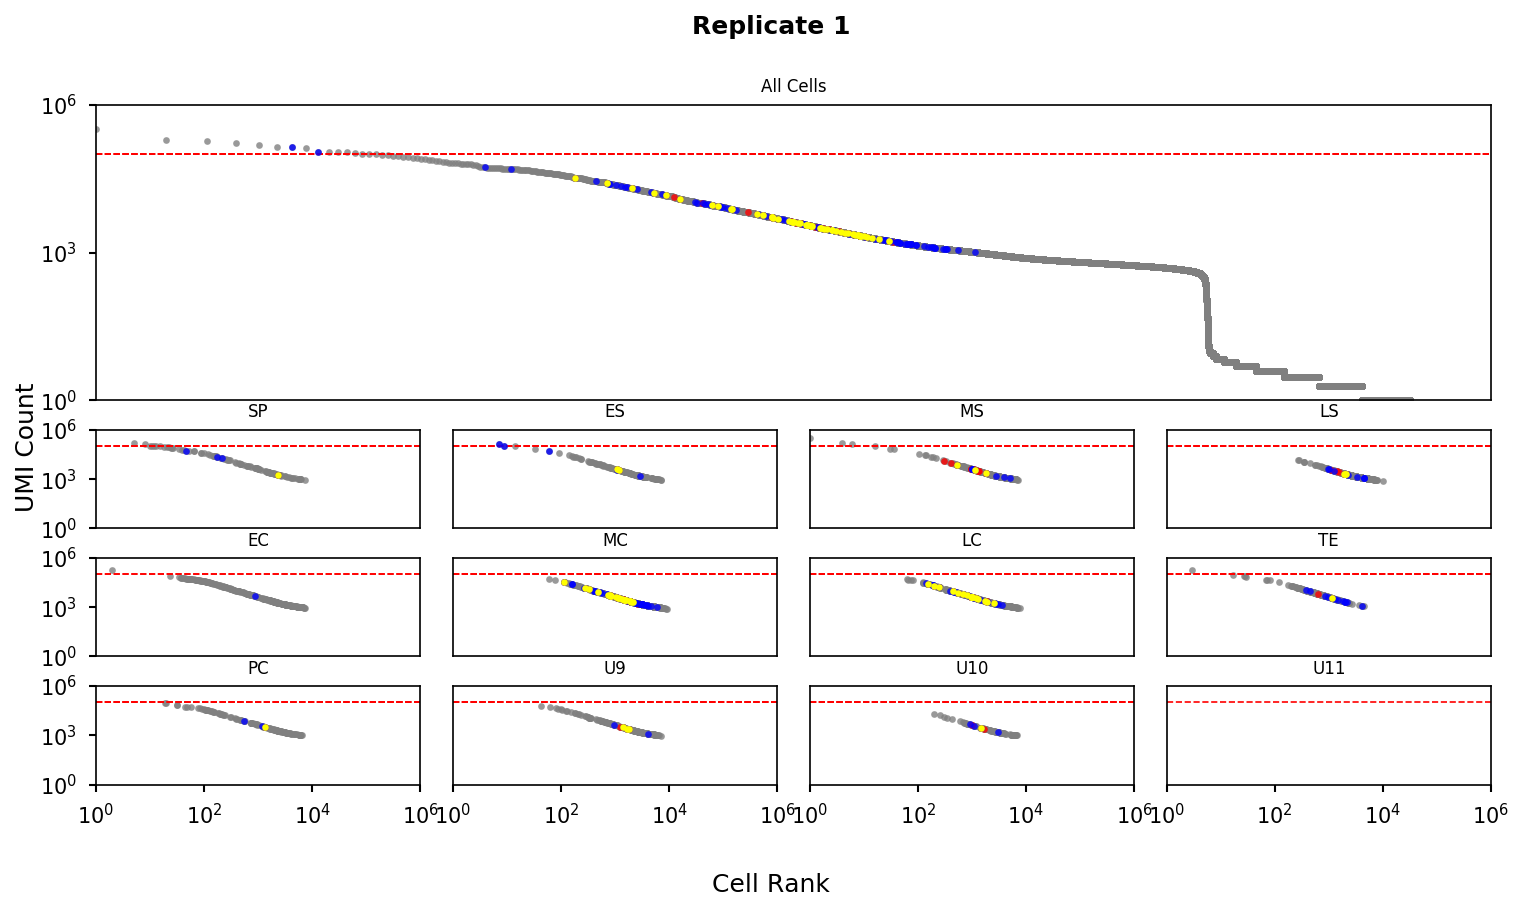

In [21]:
dat = munge('../output/scrnaseq-wf/scrnaseq_samples/testis1_force/outs/molecule_info.h5', 'rep1')
plotall(dat, 'Replicate 1')

In [22]:
df = pd.crosstab(dat['dups'], dat['dupFinder'])
df.index.name = 'DoubletDetection'
df.columns.name = 'DoubletFinder'
df.applymap(lambda x: f'{x:,}')

DoubletFinder,False,True
DoubletDetection,,
False,"461,158",88
True,29,50


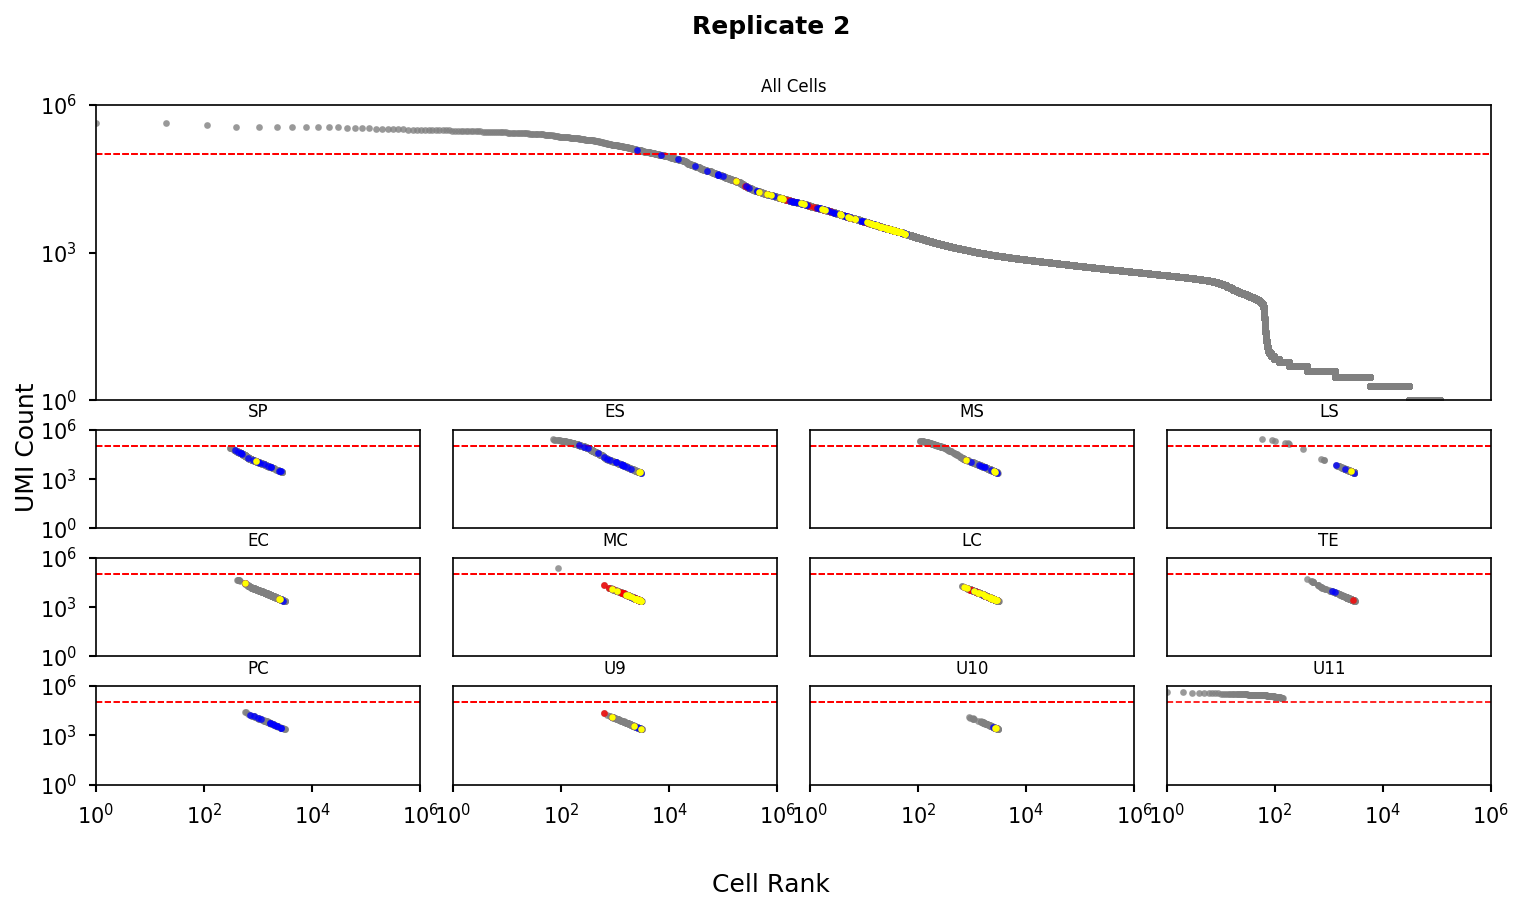

In [23]:
dat = munge('../output/scrnaseq-wf/scrnaseq_samples/testis2_force/outs/molecule_info.h5', 'rep2')
plotall(dat, 'Replicate 2')

In [24]:
df = pd.crosstab(dat['dups'], dat['dupFinder'])
df.index.name = 'DoubletDetection'
df.columns.name = 'DoubletFinder'
df.applymap(lambda x: f'{x:,}')

DoubletFinder,False,True
DoubletDetection,,
False,"612,972",85
True,40,53


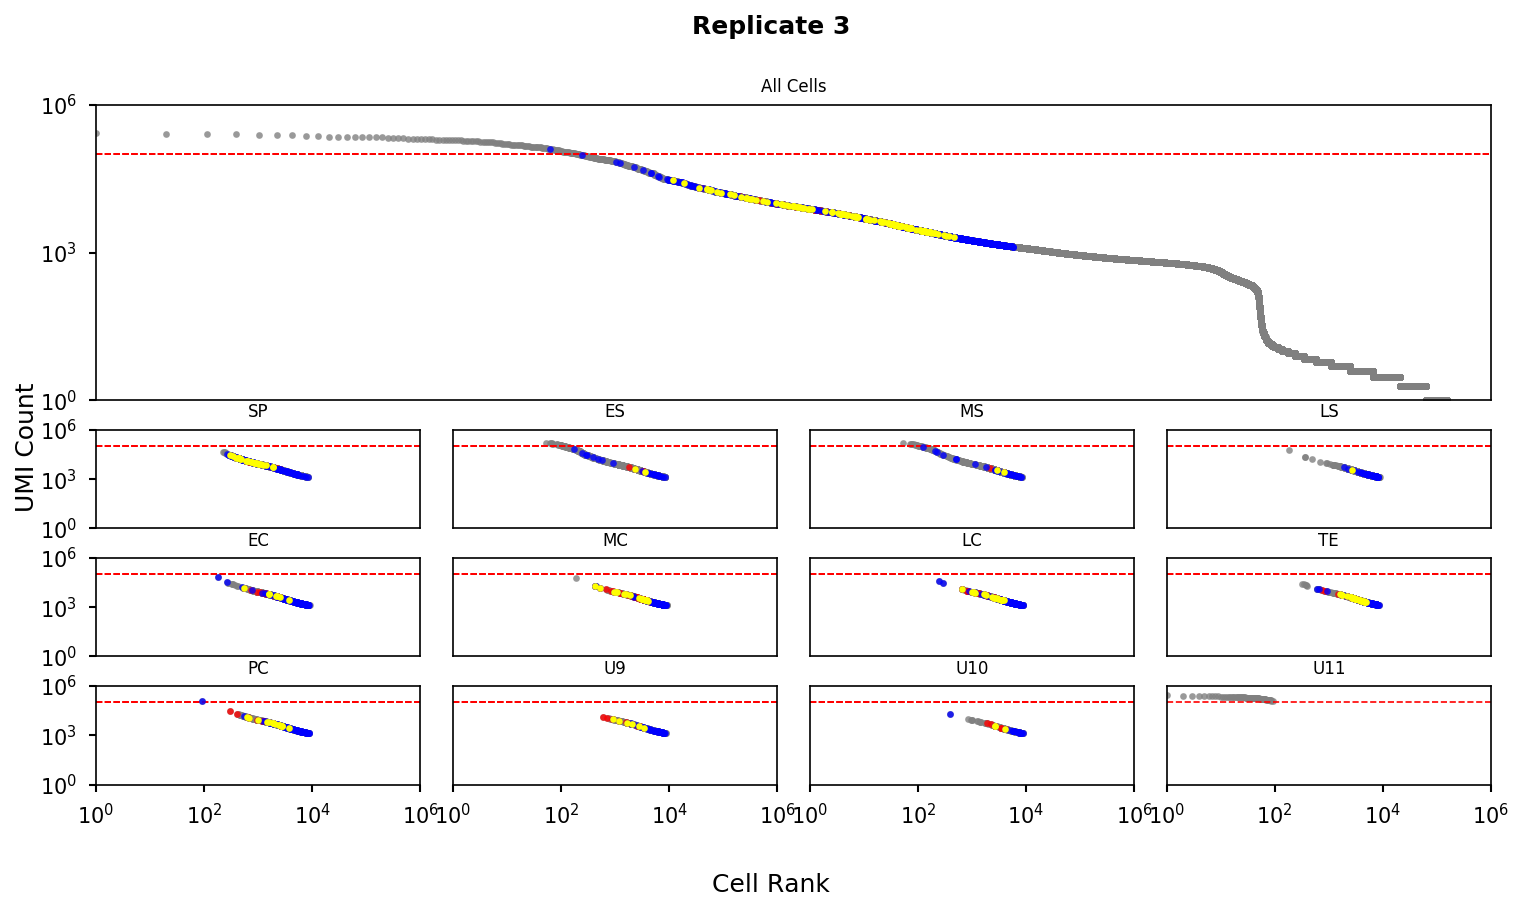

In [25]:
dat = munge('../output/scrnaseq-wf/scrnaseq_samples/testis3_force/outs/molecule_info.h5', 'rep3')
plotall(dat, 'Replicate 3')

In [26]:
df = pd.crosstab(dat['dups'], dat['dupFinder'])
df.index.name = 'DoubletDetection'
df.columns.name = 'DoubletFinder'
df.applymap(lambda x: f'{x:,}')

DoubletFinder,False,True
DoubletDetection,,
False,"654,030",862
True,148,114
